In [1]:
import itertools
from collections import defaultdict

import grinch as gr
import matplotlib as mpl
from gseapy import dotplot
from scipy.stats import hypergeom, ranksums

from aliases import *
from senset import SncGeneSets
from senset.utils import _compute_log2fc, pqvals
from textwrap import wrap
import scanpy as sc

In [2]:
# Set some color palettes
up_down_pal = ['#465775', '#ef6f6c']
gene_set_pal = ["#f6bd60","#f7ede2","#f5cac3","#84a59d","#f28482"]
cond_colors = {
    "Control": "#FFFFFF",
    "Bleo": "#fac522",
    "DMSO": "#d4d4d4",
    "Doxo": "#3f68b1",
    "Rad": "#d62828",
}
control_bleo_cols = np.array([cond_colors['Control'], cond_colors['Bleo']])
control_doxo_cols = np.array([cond_colors['DMSO'], cond_colors['Doxo']])
control_rad_cols = np.array([cond_colors['Control'], cond_colors['Rad']])

In [3]:
extension = "SNC-known-pca=10-prior=0.9-no-smoker"

In [4]:
SNC = SncGeneSets(
    SenSet=f'dumps/SenSet-{extension}.txt',
    remove_downregulated=False,
)
gene_sets = SNC.gene_sets
print(SNC)

Gene Set module with keys:
	GO: 83
	Fridman: 90
	SenMayo: 125
	CellAge: 279
	union: 501
	SenSet: 106



## Load Data

In [5]:
treatments = ['Bleomycin', 'Doxorubicin', 'Radiation']

In [6]:
patients = {}

bleo_patients = ['LTC120', 'LTC124', 'LTC113', 'LTC117']
# add None to align bleo and doxo patients
doxo_patients = [None, 'LTC124', 'LTC113', 'LTC117']
rad_patients = ['E170', 'E185', 'E187', 'E196']

for patient in tqdm(bleo_patients):
    patients[f"{patient}-Bleo"] = anndata.read_h5ad(
        f'../SenSet/data/grinch-processed/{patient}-bleo_grinch.h5ad')

for patient in tqdm(doxo_patients):
    if patient is None:
        patients[None] = None
        continue
    patients[f"{patient}-Doxo"] = anndata.read_h5ad(
        f'../SenSet/data/grinch-processed/{patient}-doxo_grinch.h5ad')

for patient in tqdm(rad_patients):
    patients[f"{patient}-Rad"] = anndata.read_h5ad(
        f'../SenSet/data/grinch-processed/{patient}-rad_grinch.h5ad')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
for adata in patients.values():
    if adata is None:
        continue
    adata.obs['leiden_str'] = adata.obs['leiden'].astype(str)

### Total counts

In [8]:
total_counts = []
for patient_name, adata in patients.items():
    if adata is None:
        continue

    control_mask = (adata.obs['batch_ID'] == 'control') | (adata.obs['batch_ID'] == 'dmso')
    x_ctrl = adata.layers['pre_normalizetotal'][control_mask].sum(1).mean()
    x_cond = adata.layers['pre_normalizetotal'][~control_mask].sum(1).mean()
    ctrl_name = "Control" if 'control' in adata.obs['batch_ID'].tolist() else 'DMSO'
    cond_name = patient_name.split('-')[-1]

    total_counts.append({
        "Sample": patient_name,
        "Condition": ctrl_name,
        "Total Counts": x_ctrl.item(),
    })
    total_counts.append({
        "Sample": patient_name,
        "Condition": cond_name,
        "Total Counts": x_cond.item(),
    })
total_counts_df = pd.DataFrame(total_counts)

In [9]:
col = ps.Colony(font_size=12)

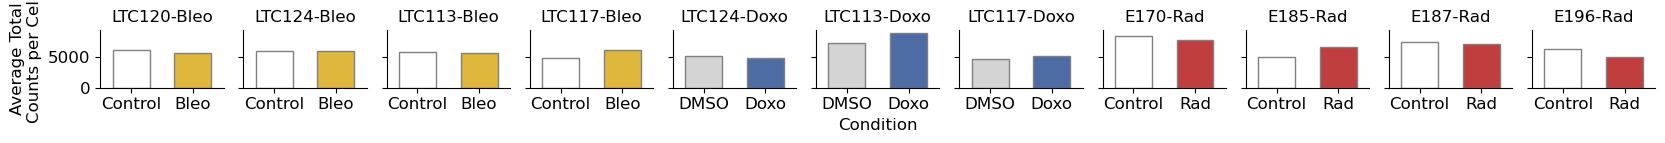

In [10]:
g = sns.catplot(
    total_counts_df,
    x="Condition",
    y="Total Counts",
    col="Sample",
    sharex=False,
    kind='bar',
    hue="Condition",
    palette=cond_colors,
    linewidth=1,
    edgecolor=".5",
    width=0.6,
    height=1.5,
)

g.set_titles("{col_name}")

for i, ax in enumerate(g.axes.flat):
    col.correct_font_size(ax)
    # ax.set_axisbelow(True)
    # ax.grid(axis='y', zorder=0)
    if i != 5:
        ax.set_xlabel('')

g.axes[0][0].set_ylabel('\n'.join(wrap("Average Total Counts per Cell", 15)))

# artist.savefig('figures/PCLS/total-counts.pdf')
plt.show()

### Check gene regulation

In [11]:
def DE_genes(patient: str, gene_set: str):
    adata = patients[patient]
    if gene_set != 'full':
        genes = getattr(SNC, gene_set)
        mask = np.in1d(adata.var_names, genes)  # take overlapping genes
    else:
        mask = np.full(adata.shape[1], True)

    patient_id, condition = patient.split('-')

    genes_tested = adata.var_names[mask].to_numpy()

    rs_key = 'rank_sum_treat_vs_control'
    treat_key = f'batch_ID-{condition.lower()}'

    # ctrl_key = 'control'
    # if ctrl_key not in adata.obs['batch_ID'].to_numpy():
    #     ctrl_key = 'dmso'

    df_res = adata.uns[rs_key][treat_key][mask]
    pvals = df_res['pvals'].to_numpy()
    statistic = df_res['statistic'].to_numpy()
    log2fc = df_res['log2fc'].to_numpy()

    pvals, qvals = pqvals(pvals)  # recompute qvals

    results = []
    for gene, p, q, l, s in zip(genes_tested, pvals, qvals, log2fc, statistic):
        results.append({
            "patient": patient,
            "patient_ID": patient_id,
            "gene_set": gene_set,
            "gene": gene,
            "p-val": p,
            "q-val": q,
            "statistic": s,
            "log2fc": l,
            "condition": condition,
        })
    return results

In [12]:
results = []
for patient in tqdm(patients):
    if patient is not None:
        for gene_set in gene_sets:
            results.append(DE_genes(patient, gene_set))
all_results = list(itertools.chain(*results))
res_df = pd.DataFrame(all_results)

res_df['-log10(p-val)'] = -np.log10(res_df['p-val'] + 1e-200)
res_df['-log10(q-val)'] = -np.log10(res_df['q-val'] + 1e-200)
res_df['Significant (p<0.05)'] = res_df['p-val'] < 0.05
res_df['Significant (q<0.05)'] = res_df['q-val'] < 0.05
res_df['Regulation'] = np.where(res_df['statistic'] >= 0, 'Up', 'Down')

  0%|          | 0/12 [00:00<?, ?it/s]

### Gene Distribution

In [13]:
def search_gene(gene: str, exps):
    for patient, adata in patients.items():
        if patient is None:
            continue
        gene_idx = adata.var_names.tolist().index(gene)

        patient_id, treat = patient.split('-')
        x_ctrl = adata.X[
            adata.obs['batch_ID'] != treat.lower(), gene_idx
        ]
        x_treat = adata.X[
            adata.obs['batch_ID'] == treat.lower(), gene_idx
        ]

        exps.append({
            "Patient": patient,
            f"{gene} Control": x_ctrl,
            f"{gene} Treat": x_treat,
        })

### Sample results

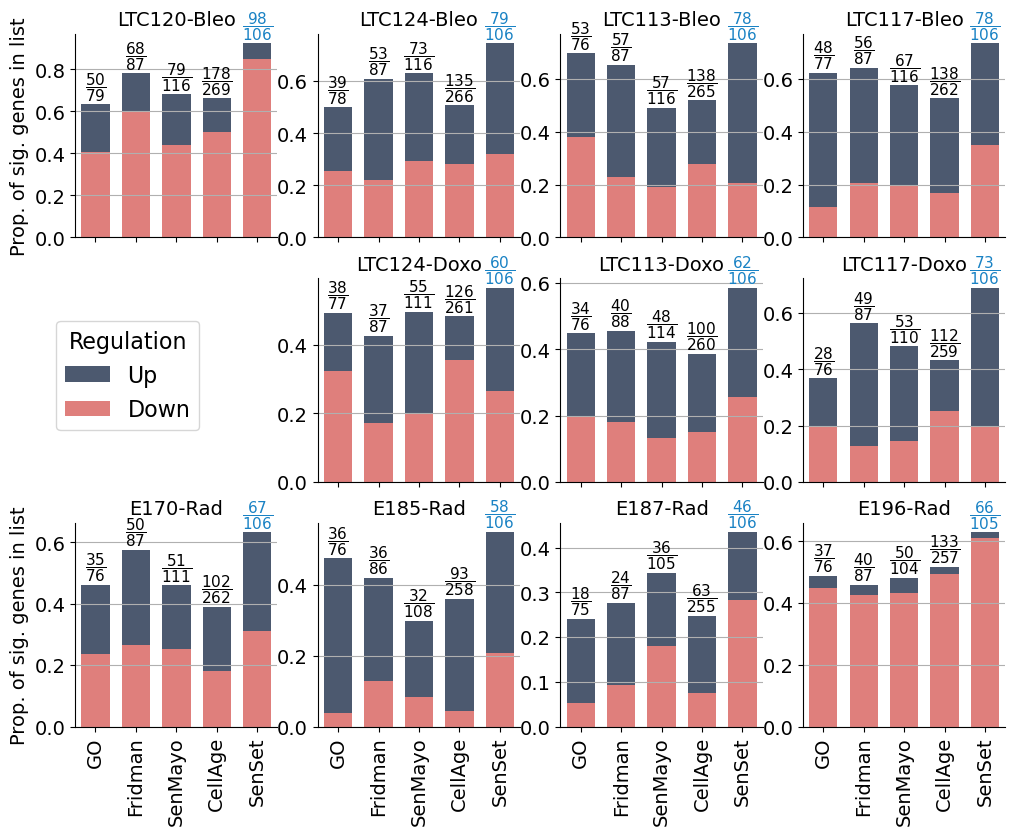

In [14]:
fig, axes = plt.subplots(
    ncols=4, nrows=3,
    figsize=(12, 9), sharex=True)

Q = 0.05
res_df[f'Significant (q<{Q})'] = res_df['q-val'] < Q
patient_to_rank = {}

for patient, ax in zip_longest(patients, axes.flat):
    if patient is None:
        ax.remove()
        continue

    _df = res_df[res_df['patient'] == patient]

    res = []
    gs_to_top_frac = Counter()
    gs_to_n_sig = Counter()
    gs_to_total = {}

    for gene_set in gene_sets:
        _dd = _df[_df['gene_set'] == gene_set]
        sup = _dd[f'Significant (q<{Q})'] & (_dd['Regulation'] == 'Up')
        sdown = _dd[f'Significant (q<{Q})'] & (_dd['Regulation'] == 'Down')
        res.append({
            "gene_set": gene_set,
            "Prop.": (sup.sum() + sdown.sum()) / len(_dd),
            "Count": sup.sum(),
            "Regulation": "Up",
        })
        res.append({
            "gene_set": gene_set,
            "Prop.": sdown.sum() / len(_dd),
            "Count": sdown.sum(),
            "Regulation": "Down",
        })

        gs_to_top_frac[gene_set] = (sup.sum() + sdown.sum()) / len(_dd)
        gs_to_n_sig[gene_set] = sup.sum() + sdown.sum()
        gs_to_total[gene_set] = len(_dd)

    _res_df = pd.DataFrame(res)

    sns.barplot(
        data=_res_df,
        hue='Regulation',
        x='gene_set',
        y='Prop.',
        hue_order=['Up', 'Down'],
        palette=up_down_pal,
        dodge=False,
        ax=ax,
        width=0.7,
    )

    patient_to_rank[patient] = gs_to_top_frac.most_common()
    best_set, best_val = gs_to_top_frac.most_common(1)[0]

    for gs, n_sig in gs_to_n_sig.items():
        ax.text(
            gs,
            gs_to_top_frac[gs] + 0.005,
            f"$\\dfrac{{{n_sig}}}{{{gs_to_total[gs]}}}$",
            ha='center',
            va='bottom',
            fontsize=11,
            color='#1982c4' if gs == best_set else 'black',
        )

    # runner_up_set, runner_up_val = gs_to_top_frac.most_common(2)[1]
    # ax.text(best_set, best_val + 0.02, '*', fontsize=16, ha='center')
    # ax.text(runner_up_set, runner_up_val + 0.02, '**', fontsize=16, ha='center')
    ax.set_title(patient)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.get_legend().remove()
    colony.correct_font_size(ax)
    ax.tick_params(axis='x', rotation=90)
    sns.despine(ax=ax)
    ax.grid(axis='y')

axes[0][0].set_ylabel('Prop. of sig. genes in list')
# axes[1][0].set_ylabel('Prop. of sig. genes in list')
axes[2][0].set_ylabel('Prop. of sig. genes in list')
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', fontsize=16,
           bbox_to_anchor=(0.1, 0.5),
           title='Regulation', title_fontproperties={'size': 16})

# artist.savefig('figures/PCLS/Validation-Proportions.pdf')
plt.show()

In [15]:
most_common_gene_set = 'SenSet'

most_common = []
_res_df = res_df[(res_df['Regulation'] == 'Up') & (res_df['gene_set'] == most_common_gene_set)]
top_up_senset = Counter(_res_df['gene']).most_common()
K_up = 8
for (upgene, count) in top_up_senset:
    if count < K_up:
        break
    most_common.append({
        "Gene": upgene,
        "Count": count,
        "Regulation": "Up",
    })
_res_df = res_df[(res_df['Regulation'] == 'Down') & (res_df['gene_set'] == most_common_gene_set)]
top_down_senset = Counter(_res_df['gene']).most_common()
K_down = 9
for (downgene, count) in top_down_senset:
    if count < K_down:
        break
    most_common.append({
        "Gene": downgene,
        "Count": count,
        "Regulation": "Down",
    })
most_common = pd.DataFrame(most_common)

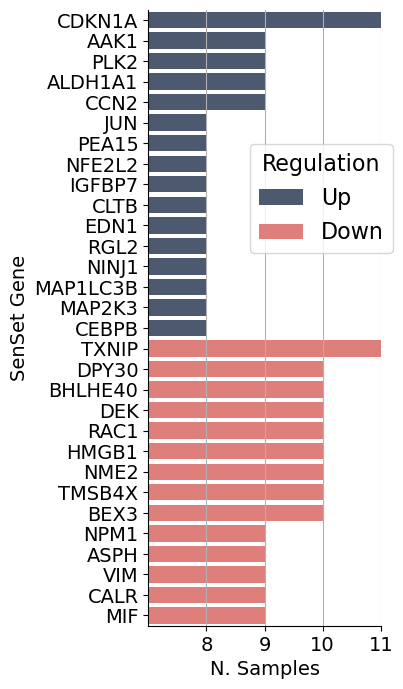

In [16]:
fig, ax = plt.subplots(figsize=(3, 8))

sns.barplot(
    most_common,
    x="Count",
    y="Gene",
    hue="Regulation",
    palette=up_down_pal,
    hue_order=["Up", "Down"],
    ax=ax,
)

ax.set_xlim(7, most_common['Count'].max())
ax.set_xticks([8, 9, 10, 11])
ax.grid(axis='x')

sns.despine(ax=ax)
ax.set_xlabel("N. Samples")
ax.set_ylabel("SenSet Gene")
colony.correct_font_size(ax)
sns.move_legend(ax, loc='upper right', bbox_to_anchor=(1.1, 0.8),
                title_fontsize=16, fontsize=16)

# artist.savefig('figures/PCLS/ValidationMostCommonSenSet.pdf')
plt.show()